# Statistical forecasting with SARIMA

In [1]:

from modules import utils
utils.configure_plotly_template(showlegend=True)

## Load data

In [2]:
path = '../../../data/statsmodels/AirPassengers_log.parquet'

In [3]:
import pandas as pd

df = pd.read_parquet(path).asfreq('ME')
df.columns = ["values"]
series = df["values"]
series

1949-01-31    4.718499
1949-02-28    4.770685
                ...   
1960-11-30    5.966147
1960-12-31    6.068426
Freq: ME, Name: values, Length: 144, dtype: float64

In [4]:
series.plot()

## Forecast

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(series, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12)) # Attention to p-values for significance
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             values   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.696
Date:                            Sat, 10 May 2025   AIC                           -483.393
Time:                                    19:57:18   BIC                           -474.767
Sample:                                01-31-1949   HQIC                          -479.888
                                     - 12-31-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4018      0.073     -5.503      0.000      -0.545      -0.259
ma.S.L12      -0.5570      0.096     -5.785      0.000      -0.746      -0.368
sigma2         0.0013      0.000      9.121      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 1.90
Prob(Q):                              0.84   Prob(JB):                         0.39
Heteroskedasticity (H):               0.58   Skew:                             0.02
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
from modules import utils

df_forecast = utils.get_model_forecast(df, 'values', order=(12, 1, 2))
df_forecast = utils.get_model_forecast(df_forecast, 'values', order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
df_forecast = utils.get_model_forecast(df_forecast, 'values', order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

df_forecast.plot(color="variable")

/Users/sota/miniforge3/envs/work/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



## Diagnostics and assumptions

In [17]:
model = SARIMAX(series, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit()

In [18]:
residuals = model_fit.resid[12+1:]
residuals

1950-02-28    0.039164
1950-03-31    0.013910
                ...   
1960-11-30   -0.027160
1960-12-31   -0.014970
Freq: ME, Length: 131, dtype: float64

### Autocorrelation

#### Plot

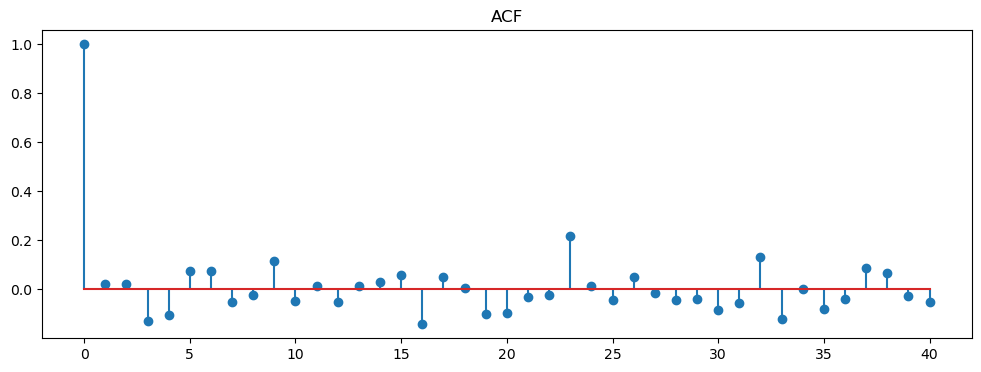

In [19]:
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

lags = 40
acf = acf(residuals, nlags=lags)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.stem(range(lags + 1), acf)
ax.set_title("ACF")
plt.show()


#### Test

In [20]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box Test:\n", lb)

Ljung-Box Test:
       lb_stat  lb_pvalue
10   8.039552   0.624973
20  15.689355   0.735699
30  26.225622   0.663567


### Normality

#### Plot

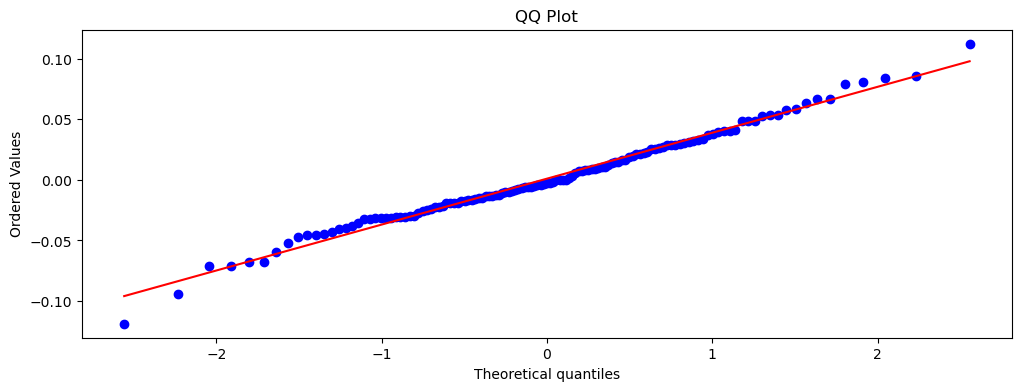

In [21]:
from scipy import stats

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title("QQ Plot")
plt.show()

#### Test

In [22]:
from scipy.stats import jarque_bera

jb = jarque_bera(residuals)

print(
    f"Jarque-Bera (Good): Statistic={jb.statistic:.3f}, p-value={jb.pvalue:.3f}"
)

Jarque-Bera (Good): Statistic=1.763, p-value=0.414


### Homoscedasticity

#### Plot

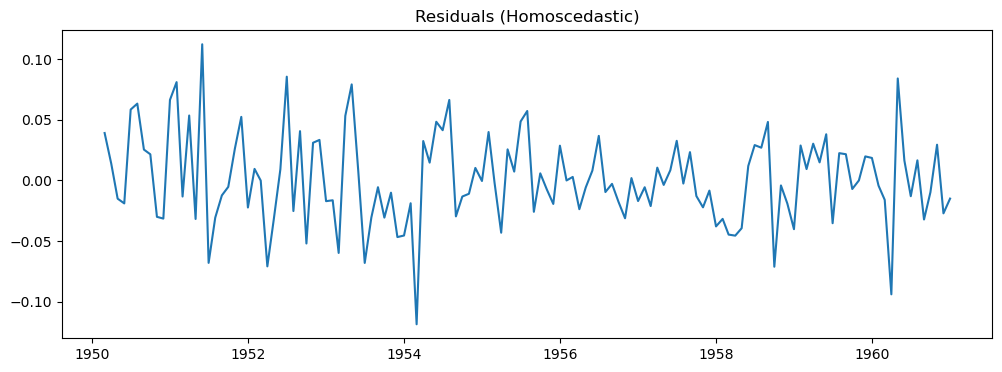

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(residuals)
ax.set_title("Residuals (Homoscedastic)")
plt.show()

#### Test

In [15]:
from statsmodels.stats.diagnostic import het_arch
arch = het_arch(residuals)

print(f"ARCH Test: LM Stat={arch[0]:.3f}, p-value={arch[1]:.3f}")

ARCH Test: LM Stat=13.665, p-value=0.189
